(magicgui)=

# Using `magicgui` in napari

## magicgui

[magicgui](https://github.com/napari/magicgui) is a python package that assists
in building small, composable graphical user interfaces (widgets). It is a general
abstraction layer on GUI toolkit backends (like Qt), with an emphasis on mapping
python types to widgets.  In particular, it makes building widgets to represent
function inputs easy:

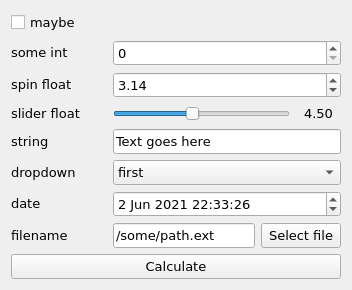

In [1]:
from magicgui import magicgui
import datetime
import pathlib

@magicgui(
    call_button="Calculate",
    slider_float={"widget_type": "FloatSlider", 'max': 10},
    dropdown={"choices": ['first', 'second', 'third']},
)
def widget_demo(
    maybe: bool,
    some_int: int,
    spin_float=3.14159,
    slider_float=4.5,
    string="Text goes here",
    dropdown='first',
    date=datetime.datetime.now(),
    filename=pathlib.Path('/some/path.ext')
):
    ...

widget_demo.show()

For more information on the features and usage of `magicgui`, see the [magicgui
documentation](https://napari.org/magicgui).  `magicgui` does not require
napari, but napari *does* provide support for using magicgui within napari. The
purpose of this page is to document some of the conveniences provided by napari
when using `magicgui` with napari-specific type annotations.

## magicgui and type annotations

`magicgui` uses [type hints](https://www.python.org/dev/peps/pep-0484/) to infer
the appropriate widget type for a given function parameter, and to indicate a
context-dependent action for the object returned from the function (in the
absense of a type hint, the type of the default value will be used).  Third
party packages (like `napari` in this case) may provide support for their types
using
[`magicgui.register_type`](https://napari.org/magicgui/usage/types_widgets.html#register-type).
This is how using the type annotations described below leads to widgets and/or
"actions" in napari.

```{important}
All of the type annotations described below *require* that the resulting widget
be added to a napari viewer (either via `viewer.window.add_dock_widget`, or
by providing a magicgui-based widget via the {func}`~napari.plugins.hook_specifications.napari_experimental_provide_dock_widget` plugin hook specification).
```

## Parameter Annotations

The following napari types may be used as *parameter* type annotations in
magicgui functions to get information from the napari viewer into your
magicgui function. The consequence of each type annotation is described below:

- any napari {class}`~napari.layers.Layer` type, such as
  {class}`~napari.layers.Image` or {class}`~napari.layers.Points`
- any of the `<LayerType>Data` types from {mod}`napari.types`, such as
  {attr}`napari.types.ImageData` or  {attr}`napari.types.LabelsData`
- {class}`napari.Viewer`

### Annotating as a `Layer` subclass

If you annotate one of your function parameters as a
{class}`~napari.layers.Layer` subclass (such as {class}`~napari.layers.Image` or
{class}`~napari.layers.Points`), it will be rendered as a
{class}`~magicgui.widgets.ComboBox` widget (i.e. "dropdown menu"), where the
options in the dropdown box are the layers of the corresponding type currently
in the viewer.

```python
from napari.layers import Image

@magicgui
def my_widget(image: Image):
    # do something with whatever image layer the user has selected
    # note: it *may* be None! so your function should handle the null case
    ...
```

Here's a complete example:

In [2]:
import napari
import numpy as np
from napari.layers import Image

@magicgui(image={'label': 'Pick an Image'})
def my_widget(image: Image):
    ...

viewer = napari.view_image(np.random.rand(64, 64), name="My Image")
viewer.window.add_dock_widget(my_widget)

*Note the widget at the bottom with "My Image" as the currently selected option*

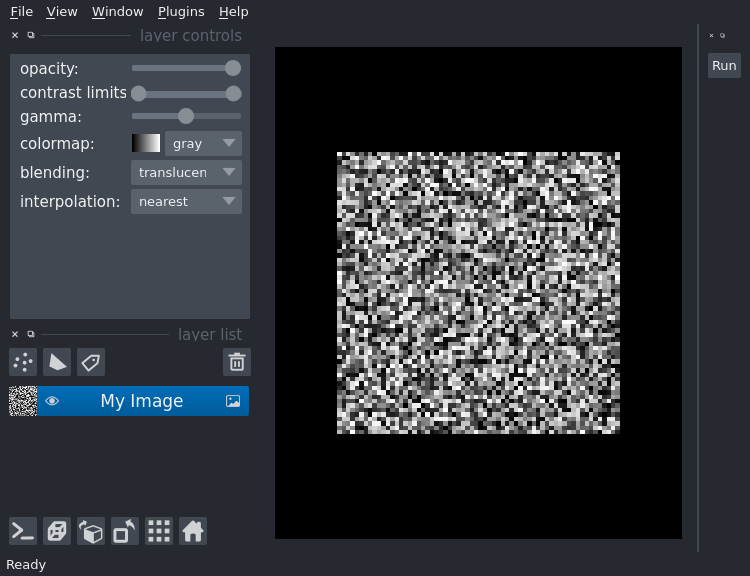

In [3]:
from napari.utils import nbscreenshot

viewer.window._qt_window.resize(750, 550)
nbscreenshot(viewer)

### Annotating as `Layer`

In the previous example, the dropdown menu will *only* show
{class}`~napari.layers.Image` layers, because the parameter was annotated as an
{class}`~napari.layers.Image`.  If you'd like a dropdown menu that allows the
user to pick from *all* layers in the layer list, annotate your parameter as
{class}`~napari.layers.Layer`

```python
from napari.layers import Layer

@magicgui
def my_widget(layer: Layer):
    # do something with whatever layer the user has selected
    # note: it *may* be None! so your function should handle the null case
    ...
```

### Annotating as `napari.types.*Data`

In the previous example, the object passed to your function will be the actual
{class}`~napari.layers.Layer` instance, meaning you will need to access any
attributes (like `layer.data`) on your own.  If your function is designed to
accept a numpy array, you can use any of the special `<LayerType>Data` types
from {mod}`napari.types` to indicate that you only want the data attribute from
the layer (where `<LayerType>` is one of the available layer types).  Here's an
example using {attr}`napari.types.ImageData`

```python
from napari.types import ImageData
import numpy as np

@magicgui
def my_widget(array: ImageData):
    # note: it *may* be None! so your function should handle the null case
    if array is not None:
      assert isinstance(array, np.ndarray)  # it will be!
```

### Annotating as `napari.Viewer`

Lastly, if you need to access the actual {class}`~napari.viewer.Viewer` instance
in which the widget is docked, you can annotate one of your parameters as a
{class}`napari.Viewer`.

```python
from napari import Viewer

@magicgui
def my_widget(viewer: Viewer):
  ...
```

```{caution}
Please use this sparingly, as a last resort. If you need to *add* layers
to the viewer from your function, prefer one of the return-annotation methods
described [below](#adding-layers-to-napari-from-your-magicgui-function).
If you find that you require the viewer instance because of functionality that
is otherwise missing here, please consider opening an issue in the
[napari issue tracker](https://github.com/napari/napari/issues/new/choose),
describing your use case.
```

## Return Annotations

The following napari types may be used as *return* type annotations in `magicgui`
functions to add layers to napari from your `magicgui` function. The consequence of
each type is described below:

- any napari {class}`~napari.layers.Layer` type, such as
  {class}`~napari.layers.Image` or {class}`~napari.layers.Points`
- any of the `<LayerType>Data` types from {mod}`napari.types`, such as
  {attr}`napari.types.ImageData` or  {attr}`napari.types.LabelsData`
- {attr}`napari.types.LayerDataTuple`

### Returning a `Layer` subclass

If you use a {class}`~napari.layers.Layer` subclass as a *return* annotation on a
`magicgui` function, `napari` will interpet it to mean that the layer returned
from the function should be added to the viewer.  The object returned from the
function must be an actual {class}`~napari.layers.Layer` instance.

```python
from napari.layers import Image
import numpy as np

@magicgui
def my_widget(ny: int=64, nx: int=64) -> Image:
  return Image(np.random.rand(ny, nx), name='my Image')
```

Here's a complete example

In [4]:
@magicgui(call_button='Add Image')
def my_widget(ny: int=64, nx: int=64) -> Image:
  return Image(np.random.rand(ny, nx), name='My Image')

viewer = napari.Viewer()
viewer.window.add_dock_widget(my_widget, area='right')
my_widget()  # "call the widget" to call the function.
             # Normally this would be caused by some user UI interaction

/home/runner/work/napari/napari/main/napari/_qt/qt_main_window.py:413: RuntimeWarning: The window geometry settings could not be loaded due to the following error: cannot unpack non-iterable NoneType object
  self.show()


<Image layer 'My Image' at 0x7f0e9a1f3670>

*Note the new "My Image" layer in the viewer as a result of having called the widget function.*

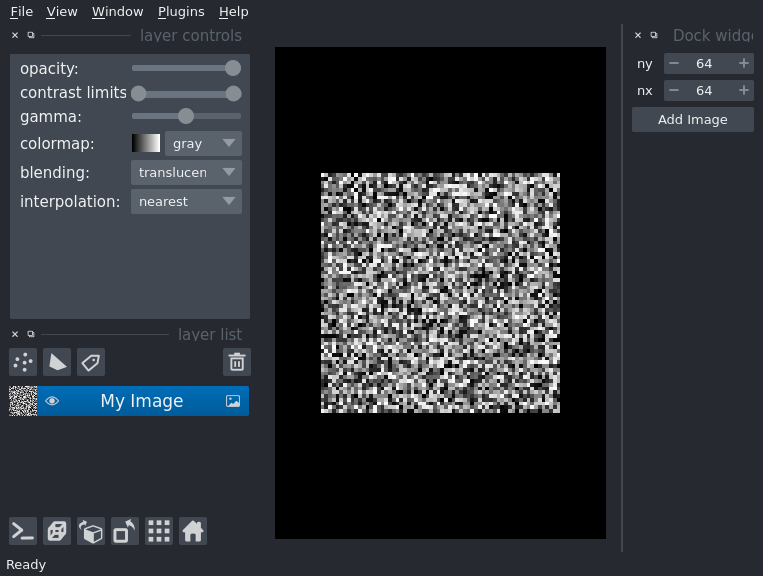

In [5]:
from napari.utils import nbscreenshot

viewer.window._qt_window.resize(750, 550)
nbscreenshot(viewer)

```{note}
With this method, a new layer will be added to the layer list each time the
function is called.  To update an existing layer, you must use the
`LayerDataTuple` approach described below
```

### Returning `napari.types.*Data`

In the previous example, the object returned by the function had to be an actual
{class}`~napari.layers.Layer` instance (in keeping with the return type
annotation).  In many cases, you may only be interested in receiving and
returning the layer {attr}`~napari.layers.Layer.data`  itself.  (There are
*many* functions already written that accept and return a `numpy.ndarray`, for
example). In this case, you may use a return type annotation of one the special
`<LayerType>Data` types from {mod}`napari.types` to indicate that you want data
returned by your function to be turned into the corresponding
{class}`~napari.layers.Layer` type, and added to the viewer.

For example, in combination with the {attr}`~napari.types.ImageData` paramater
annotation [described above](#annotating-as-napari-types-data):

In [6]:
from napari.types import LabelsData, ImageData

@magicgui(call_button='Run Threshold')
def threshold(image: ImageData, threshold: int = 75) -> LabelsData:
    """Threshold an image and return a mask."""
    return (image > threshold).astype(int)

viewer = napari.view_image(np.random.randint(0, 100, (64, 64)))
viewer.window.add_dock_widget(threshold)
threshold()  # "call the widget" to call the function.
             # Normally this would be caused by some user UI interaction

/home/runner/work/napari/napari/main/napari/_qt/qt_main_window.py:413: RuntimeWarning: The window geometry settings could not be loaded due to the following error: cannot unpack non-iterable NoneType object
  self.show()


array([[0, 0, 1, ..., 0, 0, 0],
       [1, 1, 0, ..., 0, 0, 1],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 1, 0, ..., 1, 1, 0]])

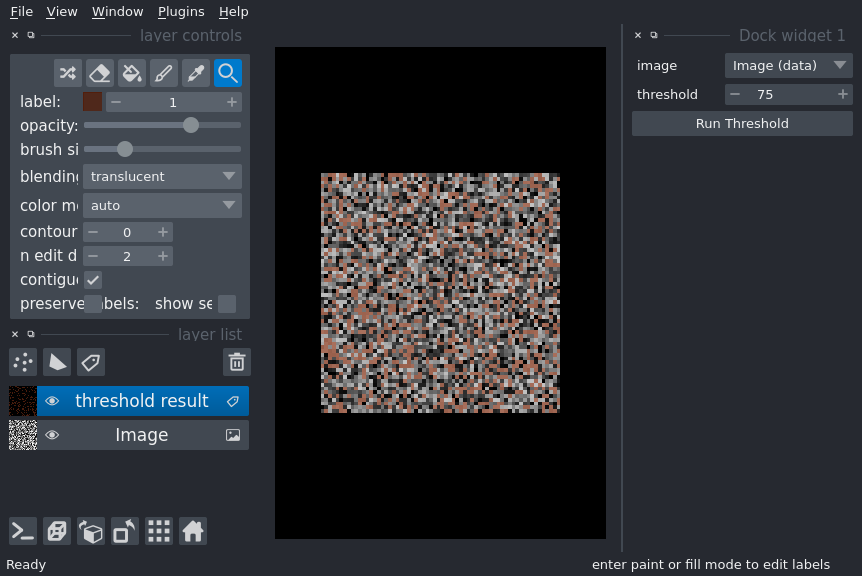

In [7]:
from napari.utils import nbscreenshot

viewer.window._qt_window.resize(750, 550)
nbscreenshot(viewer)

### Returning `napari.types.LayerDataTuple`

The most flexible return type annotation is {attr}`napari.types.LayerDataTuple`:
it gives you full control over the layer that will be created and added to the
viewer.  (It also lets you update an existing layer with a matching name).

A {attr}`~napari.types.LayerDataTuple` is a {class}`tuple` in one of the
following three forms:

1. `(layer_data,)`
   - a single item tuple containing only layer data (will be interpreted as an image).
2. `(layer_data, {})`
   - a 2-tuple of `layer_data` and a metadata {class}`dict`. the keys in the
     metadata `dict` must be valid keyword arguments to the corresponding
     {class}`napari.layers.Layer` constructor.
3. `(layer_data, {}, 'layer_type')`
   - a 3-tuple of data, metadata, and layer type string.`layer_type` should be a
     lowercase string form of one of the layer types (like `'points'`,
     `'shapes'`, etc...).  If omitted, the layer type is assumed to be
     `'image'`.

The following are all valid {attr}`napari.types.LayerDataTuple` examples:

```python
# an image array
(np.random.rand(64, 64),) 

# an image with name and custom blending mode
(np.random.rand(64, 64), {'name': 'My Image', 'blending': 'additive'})

# an empty points layer
(None, {}, 'points')

# points with properties
(np.random.rand(20, 2), {'properties': {'values': np.random.rand(20)}}, 'points')
```

An example of using a {attr}`~napari.types.LayerDataTuple` return annotation in
a `magicgui` function:

In [8]:
import napari.types

@magicgui(call_button='Make Points')
def make_points(n_points=40) -> napari.types.LayerDataTuple:
  data = 500 * np.random.rand(n_points, 2)
  props = {'values': np.random.rand(n_points)}
  return (data, {'properties': props}, 'points')

viewer = napari.Viewer()
viewer.window.add_dock_widget(make_points)
make_points()  # "call the widget" to call the function.
               # Normally this would be caused by some user UI interaction

/home/runner/work/napari/napari/main/napari/_qt/qt_main_window.py:413: RuntimeWarning: The window geometry settings could not be loaded due to the following error: cannot unpack non-iterable NoneType object
  self.show()


(array([[330.85818299,  26.40756515],
        [442.48213675, 259.58096857],
        [483.05853258, 122.67201251],
        [114.0694894 , 146.38269594],
        [ 11.77722001, 106.2354175 ],
        [414.98895009, 497.97203802],
        [ 59.81313756,  99.18216399],
        [176.90837335, 101.07050815],
        [223.38072751, 293.86786128],
        [443.17334066, 455.12769031],
        [127.21969721,  80.22833398],
        [494.93737646, 170.58367863],
        [287.75299438, 151.56223768],
        [296.39133636, 100.09985007],
        [443.54916194, 378.69915552],
        [364.35893644, 142.6067233 ],
        [472.57622607, 452.1617681 ],
        [ 49.8248327 , 325.14711332],
        [436.81622095, 232.86277437],
        [285.04360026, 295.6611447 ],
        [ 99.41820292, 463.80911373],
        [ 50.60597256, 373.22521836],
        [349.38530266, 288.49971776],
        [ 63.47862714, 422.12741519],
        [430.69225791, 132.98498979],
        [249.22921206, 429.9408076 ],
        [304

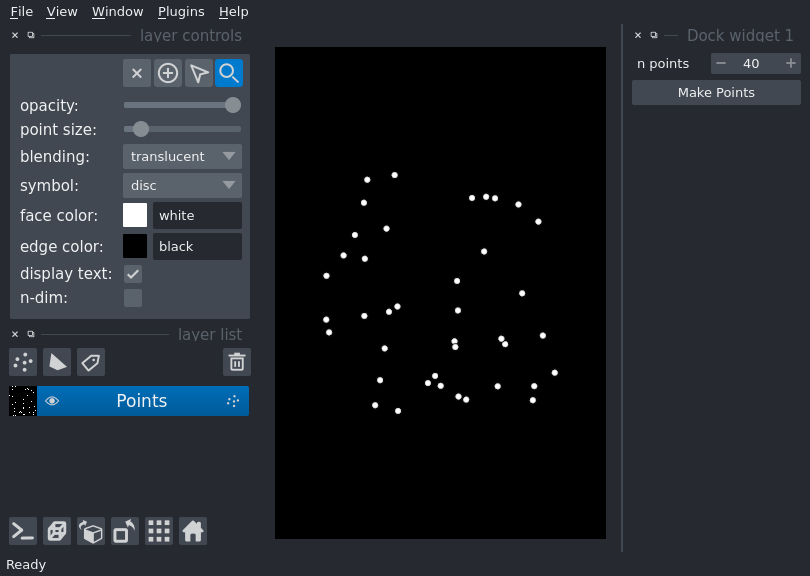

In [9]:
from napari.utils import nbscreenshot

viewer.window._qt_window.resize(750, 550)
nbscreenshot(viewer)

### Returning `List[napari.types.LayerDataTuple]`

You can also create multiple layers by returning a list of
{attr}`~napari.types.LayerDataTuple`.

```python
from typing import List

@magicgui
def make_points(...) -> List[napari.types.LayerDataTuple]:
  ...
```

```{note}
Note: the `List[]` syntax here is optional from the perspective of `napari`.  You
can return either a single tuple or a list of tuples and they will all be added
to the viewer as long as you use either `List[napari.types.LayerDataTuple]` or 
`napari.types.LayerDataTuple`.  If you want your code to be properly typed, however,
your return type must match your return annotation.
```

### Updating an existing Layer

The default behavior is to add a new layer to the viewer for each
`LayerDataTuple` returned by a magicgui function. By providing a unique
`name` key in your {attr}`~napari.types.LayerDataTuple` metadata dict, you can
update an existing layer, rather than creating a new layer each time the
function is called:

In [10]:
@magicgui(call_button='Make Points', n_points={'maximum': 200})
def make_points(n_points=40) -> napari.types.LayerDataTuple:
  data = 500 * np.random.rand(n_points, 2)
  return (data, {'name': 'My Points'}, 'points')

viewer = napari.Viewer()
viewer.window.add_dock_widget(make_points)
# calling this multiple times will just update 'My Points'
make_points()
make_points.n_points.value = 80
make_points()
make_points.n_points.value = 120
make_points()

/opt/hostedtoolcache/Python/3.8.10/x64/lib/python3.8/site-packages/magicgui/widgets/_bases/ranged_widget.py:28: FutureWarning: The 'maximum' keyword arguments has been changed to 'max'. In the future this will raise an exception

  warn(


/home/runner/work/napari/napari/main/napari/_qt/qt_main_window.py:413: RuntimeWarning: The window geometry settings could not be loaded due to the following error: cannot unpack non-iterable NoneType object
  self.show()


(array([[9.07505327e+01, 3.79769267e+02],
        [4.18557226e+02, 2.82928675e+02],
        [2.35762455e+02, 1.98298496e+02],
        [3.11038237e+02, 3.11089524e+01],
        [2.40650524e+02, 2.90050668e+02],
        [1.76655090e+01, 1.62443133e+02],
        [1.87689778e+02, 2.48511032e+02],
        [3.76691478e+02, 2.05993196e+02],
        [3.95530387e+02, 2.11155132e+02],
        [4.68954680e+02, 1.67128903e+02],
        [4.06885801e+01, 1.19375599e+02],
        [3.37308071e+02, 4.65356301e+02],
        [1.63186862e+02, 2.51638496e+02],
        [1.75009633e+02, 7.62210961e+01],
        [4.20180341e+02, 2.30347891e+02],
        [3.79438554e+01, 2.84750191e+02],
        [2.20023953e+02, 1.58262592e+02],
        [3.88881824e+02, 1.41274482e+01],
        [4.85005162e+02, 1.26019103e+02],
        [1.11714566e+02, 8.49188518e+01],
        [2.80052172e+02, 5.05535730e+01],
        [1.62431199e+02, 1.21992434e+02],
        [2.02660268e+02, 4.97361156e+02],
        [3.98409944e+02, 4.0429357

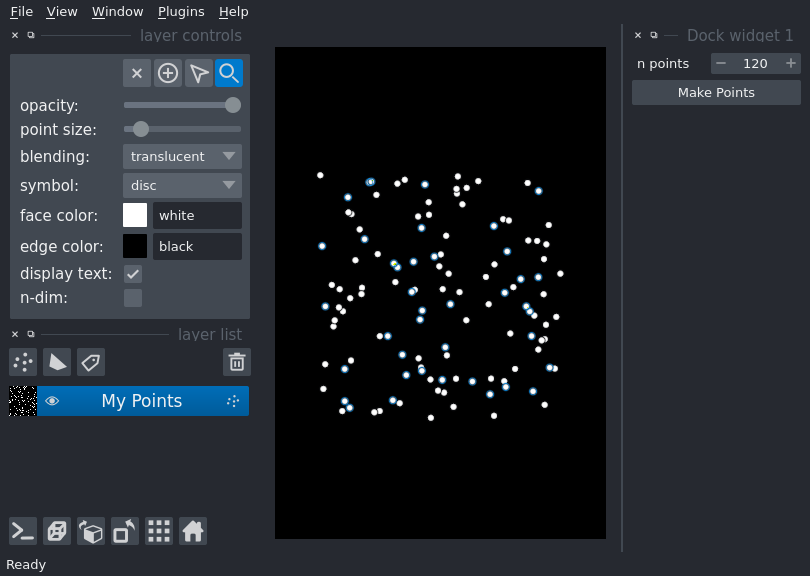

In [11]:
from napari.utils import nbscreenshot

viewer.window._qt_window.resize(750, 550)
nbscreenshot(viewer)

## Avoid imports with forward references

Sometimes, it is undesirable to import and/or depend on `napari` directly just
to provide type annotations.  It is possible to avoid importing `napari`
entirely by annotating with the string form of the napari type.  This is called
a [Forward
reference](https://www.python.org/dev/peps/pep-0484/#forward-references):

```python
@magicgui
def my_func(data: 'napari.types.ImageData') -> 'napari.types.ImageData':
    ...
```

:::{tip}

If you'd like to maintain IDE type support and autocompletion, you can
do so by hiding the napari imports inside of a {attr}`typing.TYPE_CHECKING`
clause:

```python
from typing import TYPE_CHECKING

if TYPE_CHECKING:
  import napari

@magicgui
def my_func(data: 'napari.types.ImageData') -> 'napari.types.ImageData':
    ...
```

This will not require `napari` at runtime, but if it is installed in your
development environment, you will still get all the type inference.

:::

## Using `magicgui` in napari plugin widgets

Using `magicgui` can be an effective way to generate widgets for use in napari
[plugins](../plugins/index.md), in particular the
{func}`~napari.plugins.hook_specifications.napari_experimental_provide_dock_widget`
plugin hook specification.  There is an important distinction to be made,
however, between using `magicgui` with `viewer.window.add_dock_widget`, and
using it with
{func}`~napari.plugins.hook_specifications.napari_experimental_provide_dock_widget`.

`viewer.window.add_dock_widget` expects an *instance* of a widget, like a
{class}`magicgui.widgets.Widget` or a {class}`qtpy.QtWidgets.QWidget`.
{func}`~napari.plugins.hook_specifications.napari_experimental_provide_dock_widget`,
on the other hand, expects a widget *class* (or, more broadly, a `callable` that
returns a widget instance).  There are two ways to acheive this with `magicgui`.

### `@magic_factory`

In most cases, the {func}`@magicgui <magicgui.magicgui>` decorator used in the
preceding examples can simply be replaced with the {func}`@magic_factory <magicgui.magic_factory>`
decorator, to use it as a plugin dock widget.

For example, the threshold widget [shown above](#returning-napari-types-data)
could be provided as a napari plugin as follows:

```python
from magicgui import magic_factory
from napari_plugin_engine import napari_hook_implementation

@magic_factory(auto_call=True, threshold={'max': 2 ** 16})
def threshold(
    data: 'napari.types.ImageData', threshold: int
) -> 'napari.types.LabelsData':
    return (data > threshold).astype(int)

@napari_hook_implementation
def napari_experimental_provide_dock_widget():
    return threshold
```

:::{note}
{func}`@magic_factory <magicgui.magic_factory>` behaves very much like
{func}`functools.partial`: it returns a callable that "remembers" some or
all of the parameters required for a "future" call to {func}`magicgui.magicgui`.
The parameters provided to {func}`@magic_factory <magicgui.magic_factory>` can
also be overridden when creating a widget from a factory:

```python
@magic_factory(call_button=True)
def my_factory(x: int):
    ...

widget1 = my_factory()
widget2 = my_factory(call_button=False, x={'widget_type': 'Slider'})
```

:::

### `magicgui.widgets.FunctionGui`

The other option for using `magicgui` in plugins is to directly subclass
{class}`magicgui.widgets.FunctionGui` (which is the type that is returned
by the {func}`@magicgui <magicgui.magicgui>` decorator).

```python
from magicgui.widgets import FunctionGui

def my_function(...):
    ...

class MyGui(FunctionGui):
    def __init__(self):
        super().__init__(
          my_function,
          call_button=True,
          layout='vertical',
          param_options={...}
        )
        # do whatever other initialization you want here

@napari_hook_implementation
def napari_experimental_provide_dock_widget():
    return MyGui
```